In [1]:
import ROOT

Welcome to JupyROOT 6.30/02


In [15]:
ERA = "2017"
REGION = "EE"

In [26]:
class Electron:
    def __init__(self):
        self.pt = -999.
        self.scEta = -999.
        self.mvaNoIso = -999.
        self.miniRelIso = -999.
        self.sip3d = -999
        self.deltaR = -999.
        self.passMVANoIsoWP90 = False
        self.passMVANoIsoWPLoose = False
        self.nearestJetFlavour = -999
        self.genWeight = -999.
    
    def setPt(self, pt):
        self.pt = pt
    
    def setPtCorr(self):
        self.ptCorr = self.pt*(1.0 + max(0., self.miniRelIso-0.1))
        
    def setScEta(self, scEta):
        self.scEta = scEta
        
    def setMVANoIso(self, mvaNoIso):
        self.mvaNoIso = mvaNoIso
    
    def setMiniRelIso(self, miniRelIso):
        self.miniRelIso = miniRelIso
    
    def setSIP3D(self, sip3d):
        self.sip3d = sip3d
        
    def setDeltaR(self, deltaR):
        self.deltaR = deltaR
        
    def setID(self, passMVANoIsoWP90, passMVANoIsoWPLoose):
        self.passMVANoIsoWP90 = passMVANoIsoWP90
        self.passMVANoIsoWPLoose = passMVANoIsoWPLoose
        
    def setNearestJetFlavour(self, nearestJetFlavour):
        self.nearestJetFlavour = nearestJetFlavour
        
    # Only required HcToWA Veto ID while skimming
    def passLooseID(self):
        if not (self.mvaNoIso > 0.75 or self.passMVANoIsoWP90): return False
        if not self.miniRelIso < 0.6: return False
        if not self.sip3d < 6: return False
        return True
        
    def passTightID(self):
        if not self.passMVANoIsoWP90: return False
        if not self.miniRelIso < 0.1: return False
        if not self.sip3d < 4: return False
        return True

In [27]:
def is_valid_region(eta, region):
    if region == "EB1":
        return abs(eta) < 0.8
    elif region == "EB2":
        return abs(eta) > 0.8 and abs(eta) < 1.479
    elif region == "EE":
        return abs(eta) > 1.479 and abs(eta) < 2.5
    else:
        raise ValueError(f"Region {region} is not valid")    

In [28]:
def draw_canvas(h_ljet, h_cjet, h_bjet, setLogy=False):
    h_ljet.SetStats(0); h_ljet.Scale(1./h_ljet.Integral())
    h_cjet.SetStats(0); h_cjet.Scale(1./h_cjet.Integral())
    h_bjet.SetStats(0); h_bjet.Scale(1./h_bjet.Integral())

    h_ljet.SetLineColor(ROOT.kBlack); h_ljet.SetLineWidth(2)
    h_cjet.SetLineColor(ROOT.kGreen); h_cjet.SetLineWidth(2)
    h_bjet.SetLineColor(ROOT.kBlue); h_bjet.SetLineWidth(2)

    h_ljet.GetYaxis().SetRangeUser(0., 1.)
    if setLogy:
        h_ljet.GetYaxis().SetRangeUser(1e-5, 1.)
    
    c = ROOT.TCanvas()
    c.SetLogy(setLogy)
    c.cd()
    h_ljet.Draw()
    h_cjet.Draw("same")
    h_bjet.Draw("same")
    c.Draw()

In [29]:
# Draw miniRelIso for electrons with pt > 10 GeV and pt < 40 GeV
h_ljet_mIso = ROOT.TH1F("miniRelIso_ljet", "", 60, 0, 0.6); h_ljet_mIso.SetDirectory(0)
h_cjet_mIso = ROOT.TH1F("miniRelIso_cjet", "", 60, 0, 0.6); h_cjet_mIso.SetDirectory(0)
h_bjet_mIso = ROOT.TH1F("miniRelIso_bjet", "", 60, 0, 0.6); h_bjet_mIso.SetDirectory(0)

# mvaNoIso
h_ljet_mva = ROOT.TH1F("mvaNoIso_ljet", "", 200, -1, 1); h_ljet_mva.SetDirectory(0)
h_cjet_mva = ROOT.TH1F("mvaNoIso_cjet", "", 200, -1, 1); h_cjet_mva.SetDirectory(0)
h_bjet_mva = ROOT.TH1F("mvaNoIso_bjet", "", 200, -1, 1); h_bjet_mva.SetDirectory(0)

# SIP3D
h_ljet_sip3d = ROOT.TH1F("mvaNoIso_ljet", "", 100, 0, 10); h_ljet_sip3d.SetDirectory(0)
h_cjet_sip3d = ROOT.TH1F("mvaNoIso_cjet", "", 100, 0, 10); h_cjet_sip3d.SetDirectory(0)
h_bjet_sip3d = ROOT.TH1F("mvaNoIso_bjet", "", 100, 0, 10); h_bjet_sip3d.SetDirectory(0)

f = ROOT.TFile.Open(f"Skimmed/{ERA}/ElectronOptimization_TTLL_powheg.root")
for evt in f.Events:
    electrons = []
    genWeight = evt.genWeight
    for i in range(evt.nElectrons):
        el = Electron()
        el.setPt(evt.Pt[i])
        el.setScEta(evt.scEta[i])
        el.setMVANoIso(evt.MVANoIso[i])
        el.setMiniRelIso(evt.MiniRelIso[i])
        el.setSIP3D(evt.SIP3D[i])
        el.setDeltaR(evt.DeltaR[i])
        el.setID(evt.PassMVANoIsoWP90[i], evt.PassMVANoIsoWPLoose[i])
        el.setNearestJetFlavour(evt.NearestJetFlavour[i])
        el.setPtCorr()
        electrons.append(el)
    
    for el in electrons:
        if not is_valid_region(el.scEta, REGION): continue
        if not el.deltaR < 0.4: continue
        if not el.mvaNoIso > 0.12: continue
        if not (el.ptCorr > 10. and el.ptCorr < 40.): continue
        
        if el.nearestJetFlavour == 5:
            h_bjet_mIso.Fill(el.miniRelIso, genWeight)
            h_bjet_mva.Fill(el.mvaNoIso, genWeight)
            h_bjet_sip3d.Fill(el.sip3d, genWeight)
        elif el.nearestJetFlavour == 4:
            h_cjet_mIso.Fill(el.miniRelIso, genWeight)
            h_cjet_mva.Fill(el.mvaNoIso, genWeight)
            h_cjet_sip3d.Fill(el.sip3d, genWeight)
        elif el.nearestJetFlavour == 1:
            h_ljet_mIso.Fill(el.miniRelIso, genWeight)
            h_ljet_mva.Fill(el.mvaNoIso, genWeight)
            h_ljet_sip3d.Fill(el.sip3d, genWeight)
        else:
            continue
f.Close()

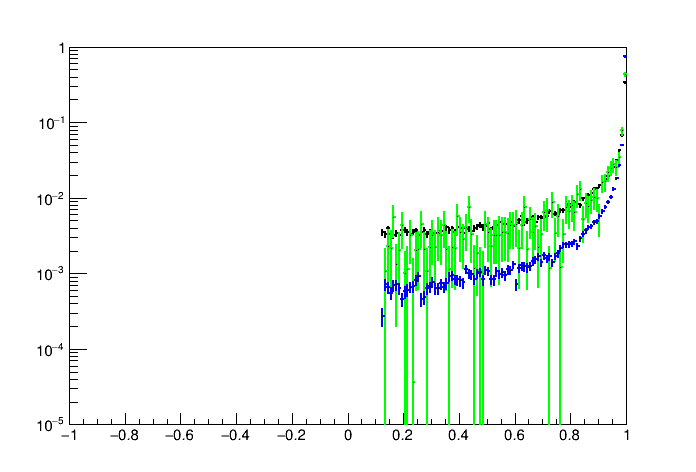

In [30]:
draw_canvas(h_ljet_mva, h_cjet_mva, h_bjet_mva, setLogy=True)

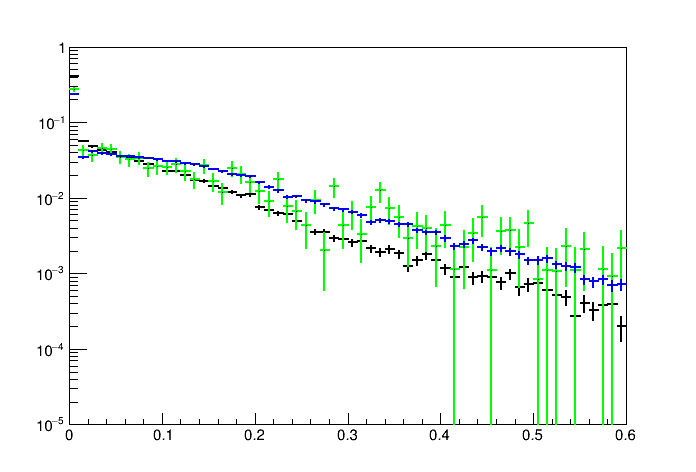

In [31]:
draw_canvas(h_ljet_mIso, h_cjet_mIso, h_bjet_mIso, setLogy=True)

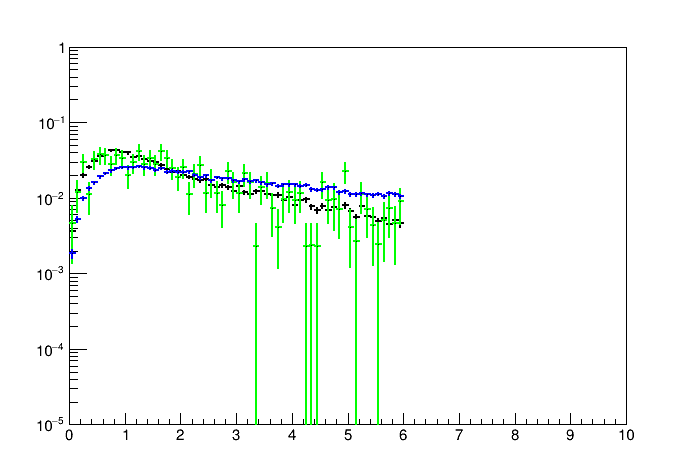

In [32]:
draw_canvas(h_ljet_sip3d, h_cjet_sip3d, h_bjet_sip3d, setLogy=True)

In [33]:
h_ljet_loose = ROOT.TH1F("ljet_loose", "", 28, 10, 150); h_ljet_loose.SetDirectory(0)
h_cjet_loose = ROOT.TH1F("cjet_loose", "", 28, 10, 150); h_cjet_loose.SetDirectory(0)
h_bjet_loose = ROOT.TH1F("bjet_loose", "", 28, 10, 150); h_bjet_loose.SetDirectory(0)

h_ljet_tight = ROOT.TH1F("ljet_tight", "", 28, 10, 150); h_ljet_tight.SetDirectory(0)
h_cjet_tight = ROOT.TH1F("cjet_tight", "", 28, 10, 150); h_cjet_tight.SetDirectory(0)
h_bjet_tight = ROOT.TH1F("bjet_tight", "", 28, 10, 150); h_bjet_tight.SetDirectory(0)

f = ROOT.TFile.Open(f"Skimmed/{ERA}/ElectronOptimization_TTLL_powheg.root")
for evt in f.Events:
    electrons = []
    genWeight = evt.genWeight
    for i in range(evt.nElectrons):
        el = Electron()
        el.setPt(evt.Pt[i])
        el.setScEta(evt.scEta[i])
        el.setMVANoIso(evt.MVANoIso[i])
        el.setMiniRelIso(evt.MiniRelIso[i])
        el.setSIP3D(evt.SIP3D[i])
        el.setDeltaR(evt.DeltaR[i])
        el.setID(evt.PassMVANoIsoWP90[i], evt.PassMVANoIsoWPLoose[i])
        el.setNearestJetFlavour(evt.NearestJetFlavour[i])
        el.setPtCorr()
        electrons.append(el)
    
    for el in electrons:
        if el.deltaR > 0.4: continue
        if not is_valid_region(el.scEta, REGION): continue
        if not el.passLooseID(): continue
        
        if el.nearestJetFlavour == 1:
            h_ljet_loose.Fill(el.ptCorr, genWeight)
            if el.passTightID(): h_ljet_tight.Fill(el.ptCorr, genWeight)
        elif el.nearestJetFlavour == 4:
            h_cjet_loose.Fill(el.ptCorr, genWeight)
            if el.passTightID(): h_cjet_tight.Fill(el.ptCorr, genWeight)
        elif el.nearestJetFlavour == 5:
            h_bjet_loose.Fill(el.ptCorr, genWeight)
            if el.passTightID(): h_bjet_tight.Fill(el.ptCorr, genWeight)
        else:
            continue
f.Close()

In [34]:
# calculate fake rate
fake_ljet = h_ljet_tight.Clone("fake_ljet"); fake_ljet.Divide(h_ljet_loose)
fake_cjet = h_cjet_tight.Clone("fake_cjet"); fake_cjet.Divide(h_cjet_loose)
fake_bjet = h_bjet_tight.Clone("fake_bjet"); fake_bjet.Divide(h_bjet_loose)

fake_ljet.SetStats(0)
fake_ljet.SetLineColor(ROOT.kBlack)
fake_ljet.SetLineWidth(2)
fake_ljet.GetXaxis().SetRangeUser(10., 100.)
fake_ljet.GetYaxis().SetRangeUser(0.01, 1.)

fake_cjet.SetStats(0)
fake_cjet.SetLineColor(ROOT.kGreen)
fake_cjet.SetLineWidth(2)

fake_bjet.SetStats(0)
fake_bjet.SetLineColor(ROOT.kBlue)
fake_bjet.SetLineWidth(2)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: cvs


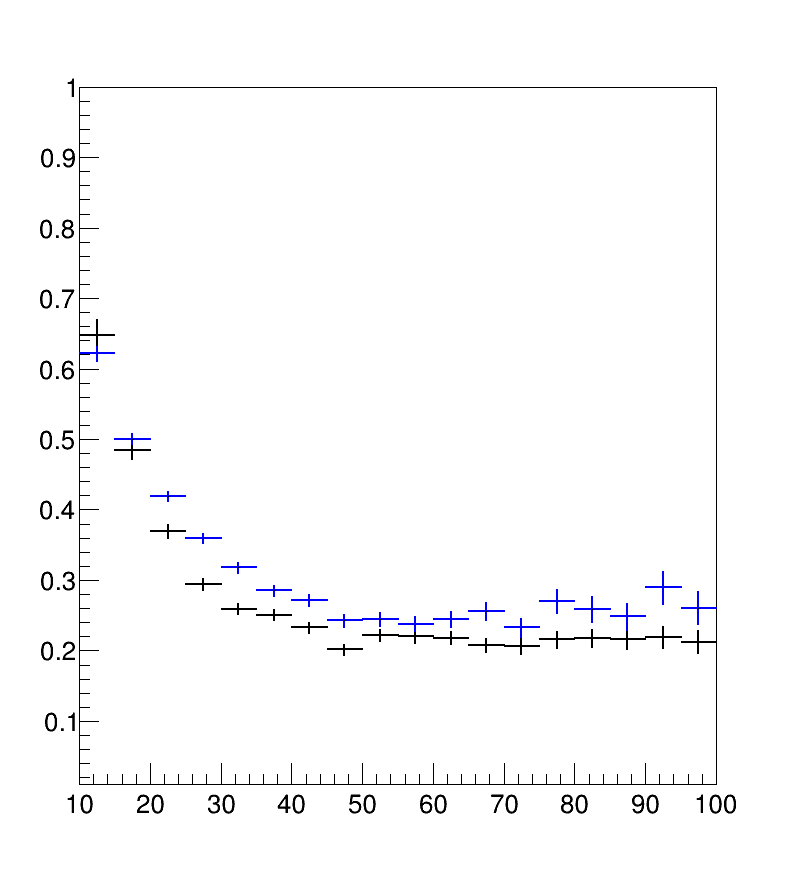

In [35]:
c = ROOT.TCanvas("cvs", "", 800, 900)
#c.SetLogy()
c.cd()
fake_ljet.Draw()
#fake_cjet.Draw("same")
fake_bjet.Draw("same")
c.Draw()